In [ ]:
import re
import copy
import nltk
import pandas as pd
import numpy as np
import konlpy
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS

In [ ]:
df_raw = pd.read_csv('./csv/traindf_musinsa_review_raw_240117.csv', sep=',', encoding='utf-8', index_col=0)
df_raw

,product_names,product_ids,user_names,user_ratings,user_reviews
0,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_cc4a349fa2d6,100,색상무난하고 기본스타일의 맨투맨입니다편해요
1,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,은비파파,100,기모인줄 알고 구입했는데 기모가 아니네요. 그럼에도 두께감도있고 기모가 아니라 부해...
2,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,거누임니닷,100,옷 색감이 딱 생각한거라 너무 좋아요 추천합니다!
3,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_e3698f46,100,오빠 선물로 간단하게 샀는데 제가 탐나서 입어보니 아방한 핏에 괜찮길래 잠깐 어디 ...
4,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,고생끝에골병난다,100,재입고 때문인지 배송이 많이 느렸는데 입어보니 소재나 핏이나 너무 맘에 들어서 잘 ...
...,...,...,...,...,...
19708,테이퍼드 밴딩 치노 팬츠 [BEIGE],DFPT2104BE,뉴비_dacde6304aba,60,음...일단 좀 작드라고요 한단계 큰거사야할듯구굿
19709,테이퍼드 밴딩 치노 팬츠 [BEIGE],DFPT2104BE,SJ0314,60,밴딩 슬랙슨데 허리가 생각보다 많이 작고 많이 늘러주진 못해요
19710,테이퍼드 밴딩 치노 팬츠 [BEIGE],DFPT2104BE,뉴비_1344cc7d,60,색감은 화면에서 봤던거보다 살짝 더 누렇고 밝은 느낌이 있어요. 허리 벨트넣는부분이...
19711,테이퍼드 밴딩 치노 팬츠 [BEIGE],DFPT2104BE,wwk1113,60,화면보다 좀 어두워요 연한 베이지는 아니에요 그래도 잘 입겠습니다.


In [ ]:
df_raw.drop_duplicates(keep='first', inplace=True, ignore_index=True)
df_raw.shape

(19713, 5)

### 레이블 달기

In [ ]:
#백업
backup = df_raw.copy()
df = backup.copy()

In [ ]:
#train data에 label 달기
df['label'] = ['pos' if r >= 80 else 'neu' if r < 80 and r >= 60 else 'neg' for r in df['user_ratings']]
df.head()

,product_names,product_ids,user_names,user_ratings,user_reviews,label
0,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_cc4a349fa2d6,100,색상무난하고 기본스타일의 맨투맨입니다편해요,pos
1,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,은비파파,100,기모인줄 알고 구입했는데 기모가 아니네요. 그럼에도 두께감도있고 기모가 아니라 부해...,pos
2,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,거누임니닷,100,옷 색감이 딱 생각한거라 너무 좋아요 추천합니다!,pos
3,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_e3698f46,100,오빠 선물로 간단하게 샀는데 제가 탐나서 입어보니 아방한 핏에 괜찮길래 잠깐 어디 ...,pos
4,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,고생끝에골병난다,100,재입고 때문인지 배송이 많이 느렸는데 입어보니 소재나 핏이나 너무 맘에 들어서 잘 ...,pos


### 토큰화

- 형태소 분석
    - Okt.pos() 는 [('아버지', 'Noun'), ...] 식으로 반환한다.
    - norm 옵션 : 그래욬ㅋㅋ -> 그래요 처럼 변환해주는 옵션
    - stem 옵션 : 원형을 찾아주는 옵션 (그래요 -> 그렇다)

In [ ]:
Okt().pos(df.user_reviews[1], stem=True, norm=True, join=True)

['기모/Noun',
 '인/Josa',
 '줄/Noun',
 '알/Noun',
 '고/Josa',
 '구입/Noun',
 '하다/Verb',
 '기모/Noun',
 '가/Josa',
 '아니다/Adjective',
 './Punctuation',
 '그렇다/Adjective',
 '두께/Noun',
 '감다/Verb',
 '기모/Noun',
 '가/Josa',
 '아니다/Adjective',
 '부/Noun',
 '해보다/Verb',
 '않다/Verb',
 '오히려/Noun',
 '잘/VerbPrefix',
 '되다/Verb',
 '같다/Adjective',
 'ㅎㅎ/KoreanParticle',
 '상체/Noun',
 '발달/Noun',
 '형/Suffix',
 '이라/Josa',
 '오버핏/Noun',
 '좋아하다/Adjective',
 '너무/Adverb',
 './Punctuation',
 '마음/Noun',
 '에/Josa',
 '들다/Verb',
 '색감/Noun',
 '도/Josa',
 '좋다/Adjective',
 '시보리/Noun',
 '도/Josa',
 '짱짱하다/Adjective',
 '말/Noun',
 '아/Josa',
 '넣다/Verb',
 '빠지다/Verb',
 '없다/Adjective',
 '좋다/Adjective',
 'ㅎ/KoreanParticle']

In [ ]:
stopwords = ['의/Josa','가/Josa','이/Josa','은/Josa','들/Josa','는/Josa','좀/Noun','걍/Noun','과/Josa','도/Josa','를/Josa','으로/Josa','에/Josa','와/Josa','한/Noun','하다/Verb','을/Josa',
             '에서/Josa','에게/Josa', '하고/Josa', '이다/Verb', './Punctuation']

In [ ]:
from tqdm.notebook import tqdm

def okt_pos_tokenizer(doc):
    result = []

    for sentence in tqdm(doc):
        tokenized_sentence = Okt().pos(sentence, norm=True, stem=True, join=True)
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        result.append(stopwords_removed_sentence)
    return result

df['token'] = okt_pos_tokenizer(df['user_reviews'])

  0%|          | 0/19713 [00:00<?, ?it/s]

In [ ]:
df.head()

,product_names,product_ids,user_names,user_ratings,user_reviews,label,token
0,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_cc4a349fa2d6,100,색상무난하고 기본스타일의 맨투맨입니다편해요,pos,"[색상/Noun, 무난/Noun, 기/Modifier, 본/Modifier, 스타일..."
1,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,은비파파,100,기모인줄 알고 구입했는데 기모가 아니네요. 그럼에도 두께감도있고 기모가 아니라 부해...,pos,"[기모/Noun, 인/Josa, 줄/Noun, 알/Noun, 고/Josa, 구입/N..."
2,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,거누임니닷,100,옷 색감이 딱 생각한거라 너무 좋아요 추천합니다!,pos,"[옷/Noun, 색감/Noun, 딱/Adverb, 생각/Noun, 한/Determi..."
3,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_e3698f46,100,오빠 선물로 간단하게 샀는데 제가 탐나서 입어보니 아방한 핏에 괜찮길래 잠깐 어디 ...,pos,"[오빠/Noun, 선물/Noun, 로/Josa, 간단하다/Adjective, 사다/..."
4,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,고생끝에골병난다,100,재입고 때문인지 배송이 많이 느렸는데 입어보니 소재나 핏이나 너무 맘에 들어서 잘 ...,pos,"[재/Noun, 입다/Verb, 때문/Noun, 인지/Josa, 배송/Noun, 많..."


### 등장 빈도 적으면 지우기

- 등장하는 단어의 빈도수 먼저 확인하고, 빈도수가 적으면 지워버리기


In [ ]:
# 시리즈를 리스트화
tmp_token = []

for text in df.token:
    tmp_token += text

tmp_token

['색상/Noun',
 '무난/Noun',
 '기/Modifier',
 '본/Modifier',
 '스타일/Noun',
 '맨투맨/Noun',
 '이다/Adjective',
 '편하다/Adjective',
 '기모/Noun',
 '인/Josa',
 '줄/Noun',
 '알/Noun',
 '고/Josa',
 '구입/Noun',
 '기모/Noun',
 '아니다/Adjective',
 '그렇다/Adjective',
 '두께/Noun',
 '감다/Verb',
 '기모/Noun',
 '아니다/Adjective',
 '부/Noun',
 '해보다/Verb',
 '않다/Verb',
 '오히려/Noun',
 '잘/VerbPrefix',
 '되다/Verb',
 '같다/Adjective',
 'ㅎㅎ/KoreanParticle',
 '상체/Noun',
 '발달/Noun',
 '형/Suffix',
 '이라/Josa',
 '오버핏/Noun',
 '좋아하다/Adjective',
 '너무/Adverb',
 '마음/Noun',
 '들다/Verb',
 '색감/Noun',
 '좋다/Adjective',
 '시보리/Noun',
 '짱짱하다/Adjective',
 '말/Noun',
 '아/Josa',
 '넣다/Verb',
 '빠지다/Verb',
 '없다/Adjective',
 '좋다/Adjective',
 'ㅎ/KoreanParticle',
 '옷/Noun',
 '색감/Noun',
 '딱/Adverb',
 '생각/Noun',
 '한/Determiner',
 '거/Noun',
 '라/Josa',
 '너무/Adverb',
 '좋다/Adjective',
 '추천/Noun',
 '!/Punctuation',
 '오빠/Noun',
 '선물/Noun',
 '로/Josa',
 '간단하다/Adjective',
 '사다/Verb',
 '제/Noun',
 '타다/Verb',
 '입어보다/Verb',
 '아/Exclamation',
 '방한/Noun',
 '핏/Noun',
 '괜찮다/Adjective',
 '잠깐/N

In [ ]:
ko = nltk.Text(tmp_token)
ko_freq = ko.vocab()
ko_freq

FreqDist({'좋다/Adjective': 10164, '입다/Verb': 8431, '같다/Adjective': 5719, '너무/Adverb': 5146, '있다/Adjective': 3870, '이쁘다/Adjective': 3762, '핏/Noun': 3597, '사이즈/Noun': 3416, '예쁘다/Adjective': 3329, '이다/Adjective': 3305, ...})

In [ ]:
threshold = 3
total_cnt = len(ko_freq) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in ko_freq.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11359
등장 빈도가 2번 이하인 희귀 단어의 수: 6560
단어 집합에서 희귀 단어의 비율: 57.75156263755612
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.352789995385541


- 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지.
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 2.35%.
- 등장 빈도가 2회 이하인 단어들은 제거

In [ ]:
remove_token = []

for k, v in ko_freq.items():
    if v < 3:
        remove_token.append(k)

remove_token[:3]

['데코/Noun', '서무/Noun', '옴택/Noun']

In [ ]:
stopwords += remove_token

In [ ]:
df['token'] = okt_pos_tokenizer(df['user_reviews'])

  0%|          | 0/19713 [00:00<?, ?it/s]

### Vectorizer + MultinomialNB

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df['vect'] = [' '.join(text) for text in df.token]

In [ ]:
df.head()

,product_names,product_ids,user_names,user_ratings,user_reviews,label,token,vect
0,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_cc4a349fa2d6,100,색상무난하고 기본스타일의 맨투맨입니다편해요,pos,"[색상/Noun, 무난/Noun, 기/Modifier, 본/Modifier, 스타일...",색상/Noun 무난/Noun 기/Modifier 본/Modifier 스타일/Noun...
1,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,은비파파,100,기모인줄 알고 구입했는데 기모가 아니네요. 그럼에도 두께감도있고 기모가 아니라 부해...,pos,"[기모/Noun, 인/Josa, 줄/Noun, 알/Noun, 고/Josa, 구입/N...",기모/Noun 인/Josa 줄/Noun 알/Noun 고/Josa 구입/Noun 기모...
2,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,거누임니닷,100,옷 색감이 딱 생각한거라 너무 좋아요 추천합니다!,pos,"[옷/Noun, 색감/Noun, 딱/Adverb, 생각/Noun, 한/Determi...",옷/Noun 색감/Noun 딱/Adverb 생각/Noun 한/Determiner 거...
3,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,뉴비_e3698f46,100,오빠 선물로 간단하게 샀는데 제가 탐나서 입어보니 아방한 핏에 괜찮길래 잠깐 어디 ...,pos,"[오빠/Noun, 선물/Noun, 로/Josa, 간단하다/Adjective, 사다/...",오빠/Noun 선물/Noun 로/Josa 간단하다/Adjective 사다/Verb ...
4,[기모버전추가]시그니처 오버핏 맨투맨(4col),P00000NE,고생끝에골병난다,100,재입고 때문인지 배송이 많이 느렸는데 입어보니 소재나 핏이나 너무 맘에 들어서 잘 ...,pos,"[재/Noun, 입다/Verb, 때문/Noun, 인지/Josa, 배송/Noun, 많...",재/Noun 입다/Verb 때문/Noun 인지/Josa 배송/Noun 많이/Adve...


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['vect'], df['label'], test_size=0.2, random_state=13)

# Convert the text data into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train_vectorized, y_train)

# Make predictions on the test set
pred = multinomialNB.predict(X_test_vectorized)
pred_proba = multinomialNB.predict_proba(X_test_vectorized
                                         )
# Evaluate the model
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, pred))

Accuracy: 0.83
              precision    recall  f1-score   support

         neg       0.85      0.11      0.19       276
         neu       0.00      0.00      0.00       416
         pos       0.83      1.00      0.91      3251

    accuracy                           0.83      3943
   macro avg       0.56      0.37      0.37      3943
weighted avg       0.75      0.83      0.76      3943



- 다른 점수 확인하기
- 다중클래스의 f1_score의 평균
    - 라벨의 중요도에 따라 어떤 지표를 선택할지가 달라진다.
    - 모든 라벨이 유사한 중요도를 가진다면 macro average 값을 참고하고
    - 샘플이 많은 라벨에 중요도를 두고 싶다면 weighted average 값을 참고하면 된다
    - 그리고 라벨에 상관없이 전체적인 성능을 평가하고 싶을 때는 micro average, 즉 accuracy 를 활용하면 된다.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def get_clf_evalscore(y_test, pred, pred_proba):
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='macro')
    pre = precision_score(y_test, pred, average='macro')
    rec = recall_score(y_test, pred, average='macro')
    # auc = roc_auc_score(y_test, pred_proba[:,1], multi_class='ovr')   #다름. 주의

    return acc, pre, rec, f1

from sklearn.metrics import confusion_matrix

def print_clf_evalmatrix(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, rec, f1 = get_clf_evalscore(y_test, pred, pred_proba)

    print('==> Confusion Matrix')
    print(confusion)
    print('=====================')
    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}'.format(rec, f1))

In [ ]:
print_clf_evalmatrix(y_test, pred, pred_proba)

==> Confusion Matrix
[[  29    0  247]
 [   5    0  411]
 [   0    1 3250]]
Accuracy: 0.8316, Precision: 0.5615
Recall: 0.3683, F1: 0.3650


### Oversampling

<Axes: xlabel='label'>

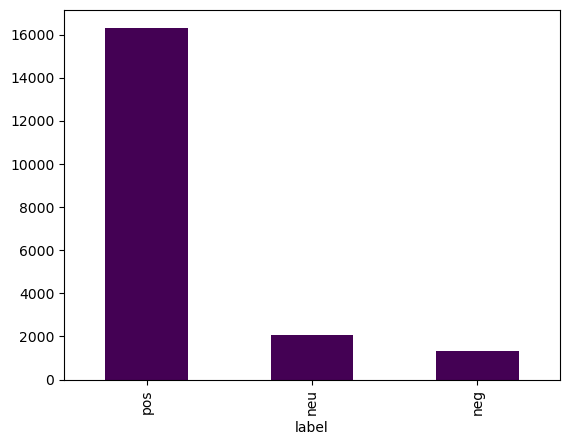

In [ ]:
df['label'].value_counts().plot(kind = 'bar', colormap='viridis')

- 데이터 비율 차이가 많이 난다. Oversampling으로 비율을 맞춰줄 필요가 있어 보인다.

In [ ]:
# SMOTE 적용
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_vectorized_over, y_train_over = smote.fit_resample(X_train_vectorized, y_train)   #트레인만 건드림

# 얼마나 불어났는지 확인
X_train_vectorized.shape, y_train.shape, X_train_vectorized_over.shape, y_train_over.shape

((15770, 3831), (15770,), (39231, 3831), (39231,))

In [ ]:
print(np.unique(y_train_over, return_counts=True))

(array(['neg', 'neu', 'pos'], dtype=object), array([13077, 13077, 13077], dtype=int64))


### 다시 MultinomialNB

In [ ]:
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_vectorized_over, y_train_over)

# Make predictions on the test set
pred = mnb_clf.predict(X_test_vectorized)
pred_proba = mnb_clf.predict_proba(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, pred))

Accuracy: 0.72
              precision    recall  f1-score   support

         neg       0.45      0.62      0.52       276
         neu       0.21      0.44      0.28       416
         pos       0.93      0.77      0.84      3251

    accuracy                           0.72      3943
   macro avg       0.53      0.61      0.55      3943
weighted avg       0.82      0.72      0.76      3943



In [ ]:
print_clf_evalmatrix(y_test, pred, pred_proba)

==> Confusion Matrix
[[ 172   75   29]
 [  65  182  169]
 [ 147  616 2488]]
Accuracy: 0.7208, Precision: 0.5276
Recall: 0.6087, F1: 0.5472


### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=13, n_jobs=-1, n_estimators=1000,
                          num_leaves=64, boost_from_average=False)

lgbm_clf.fit(X_train_vectorized_over, y_train_over)
lgbm_pred = lgbm_clf.predict(X_test_vectorized)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test_vectorized)

print_clf_evalmatrix(y_test, lgbm_pred, lgbm_pred_proba)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197001
[LightGBM] [Info] Number of data points in the train set: 39231, number of used features: 2380
==> Confusion Matrix
[[ 127   41  108]
 [  38   62  316]
 [  33   84 3134]]
Accuracy: 0.8428, Precision: 0.6179
Recall: 0.5244, F1: 0.5540


### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train_vectorized_over, y_train_over)
lr_pred = lr_clf.predict(X_test_vectorized)
lr_pred_proba = lr_clf.predict_proba(X_test_vectorized)

print_clf_evalmatrix(y_test, lr_pred, lr_pred_proba)

==> Confusion Matrix
[[ 183   62   31]
 [  77  152  187]
 [ 139  511 2601]]
Accuracy: 0.7446, Precision: 0.5303
Recall: 0.6095, F1: 0.5552


- 모델 별로 Precision과 Recall에서 큰 차이가 없기 때문에 Accuracy가 가장 높은 LightGBM으로 사용.

### GridSearchCV

- 너무 오래 걸려서 일단 패스

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for grid search
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'num_leaves': [32, 64, 128],
#     'learning_rate': [0.01, 0.05, 0.1]
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(lgbm_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train_vectorized_over, y_train_over)

# # Get the best parameters from grid search
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Use the best model for predictions
# best_lgbm_clf = grid_search.best_estimator_
# lgbm_pred = best_lgbm_clf.predict(X_test_vectorized)
# lgbm_pred_proba = best_lgbm_clf.predict_proba(X_test_vectorized)

# # Print evaluation metrics
# print_clf_evalmatrix(y_test, lgbm_pred, lgbm_pred_proba)

### 크롤링한 리뷰 넣어 predict하기
- 벡터라이즈는 train_set에 대해서만 fit_transform 해야 함
- test 데이터와 predict 데이터에 대해서는 transform만

In [ ]:
target_df = pd.read_csv('./csv/review_240119.csv', index_col=0)
target_df = target_df[target_df.columns[:-1]]
target_df

,product_names,product_ids,user_names,user_ratings,user_reviews
0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌
1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...
2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..
3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다
4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.
...,...,...,...,...,...
179772,레이싱 자켓,G2301JK04BK/G2301JK04IV,민이후니,100,비록 클리어런스 제품이지만 제품 자체는 덜 할인이 들어가도 구매 할 만큼 충분히 퀄...
179774,레이싱 자켓,G2301JK04BK/G2301JK04IV,Kobe-Ju,100,퀄리티좋고 배송빨라요 패키지도 잘되있어서 선물하기에도 용이해보이고 일단 착용감도 굿...
179775,레이싱 자켓,G2301JK04BK/G2301JK04IV,dossl,100,상품 잘 받았습니다 퀄리티도 괜찮아보이고 디자인도 맘에들어서 자주 사용할 것 같아요...
179777,레이싱 자켓,G2301JK04BK/G2301JK04IV,와라링,100,예쁩니다. 추천합니다 그렇지만 유일한 단점은 투웨이가 아니라는 점입니다. 더울때는 ...


In [ ]:
#토큰화
target_df['token'] = tqdm(okt_pos_tokenizer(target_df['user_reviews']))

  0%|          | 0/143562 [00:00<?, ?it/s]

  0%|          | 0/143562 [00:00<?, ?it/s]

In [ ]:
#벡터라이즈 준비
target_df['vect'] = [' '.join(text) for text in tqdm(target_df.token)]

  0%|          | 0/143562 [00:00<?, ?it/s]

In [ ]:
target_df

,product_names,product_ids,user_names,user_ratings,user_reviews,token,vect
0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,"[깔끔하다/Adjective, 입다/Verb, 편안하다/Adjective, 손/No...",깔끔하다/Adjective 입다/Verb 편안하다/Adjective 손/Noun 자...
1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,"[오버/Noun, 한/Josa, 사이즈/Noun, 고/Josa, 입다/Verb, 더...",오버/Noun 한/Josa 사이즈/Noun 고/Josa 입다/Verb 더/Noun ...
2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,"[많이/Adverb, 길다/Adjective, 오버/Noun, 줄/Noun, 알다/...",많이/Adverb 길다/Adjective 오버/Noun 줄/Noun 알다/Verb ...
3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,"[굿굿/Noun, 생각/Noun, 한/Determiner, 거/Noun, 보다/Jo...",굿굿/Noun 생각/Noun 한/Determiner 거/Noun 보다/Josa 이쁘...
4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,"[살짝/Noun, 얇다/Adjective, 원단/Noun, 아쉽다/Adjective...",살짝/Noun 얇다/Adjective 원단/Noun 아쉽다/Adjective 전체/...
...,...,...,...,...,...,...,...
179772,레이싱 자켓,G2301JK04BK/G2301JK04IV,민이후니,100,비록 클리어런스 제품이지만 제품 자체는 덜 할인이 들어가도 구매 할 만큼 충분히 퀄...,"[제품/Noun, 이지만/Josa, 제품/Noun, 자체/Noun, 덜/Noun, ...",제품/Noun 이지만/Josa 제품/Noun 자체/Noun 덜/Noun 할인/Nou...
179774,레이싱 자켓,G2301JK04BK/G2301JK04IV,Kobe-Ju,100,퀄리티좋고 배송빨라요 패키지도 잘되있어서 선물하기에도 용이해보이고 일단 착용감도 굿...,"[퀄리티/Noun, 좋다/Adjective, 배송/Noun, 빨르다/Adjectiv...",퀄리티/Noun 좋다/Adjective 배송/Noun 빨르다/Adjective 패키...
179775,레이싱 자켓,G2301JK04BK/G2301JK04IV,dossl,100,상품 잘 받았습니다 퀄리티도 괜찮아보이고 디자인도 맘에들어서 자주 사용할 것 같아요...,"[상품/Noun, 자다/Verb, 받다/Verb, 퀄리티/Noun, 괜찮다/Adje...",상품/Noun 자다/Verb 받다/Verb 퀄리티/Noun 괜찮다/Adjective...
179777,레이싱 자켓,G2301JK04BK/G2301JK04IV,와라링,100,예쁩니다. 추천합니다 그렇지만 유일한 단점은 투웨이가 아니라는 점입니다. 더울때는 ...,"[예쁘다/Adjective, 추천/Noun, 그렇지만/Conjunction, 유일하...",예쁘다/Adjective 추천/Noun 그렇지만/Conjunction 유일하다/Ad...


In [ ]:
# 벡터라이즈
# 기존의 vectorizer에 넣어 transform만 하기
# 여기서 fit 또는 fit_transform을 하면 새로운 기준으로 vectorized 됨
target_review_vectorized = vectorizer.transform(target_df['vect'])

In [ ]:
X_train_vectorized_over

<39231x3831 sparse matrix of type '<class 'numpy.float64'>'
	with 1579863 stored elements in Compressed Sparse Row format>

In [ ]:
target_review_vectorized

<143562x3831 sparse matrix of type '<class 'numpy.float64'>'
	with 2465145 stored elements in Compressed Sparse Row format>

In [ ]:
# 리뷰 감성 예측
lgbm_predicted_sent = lgbm_clf.predict(target_review_vectorized)
target_df['lgbm_predicted_sent'] = lgbm_predicted_sent

In [ ]:
target_df.to_csv('review_lgbm_240121.csv', sep=',', encoding='utf-8')

In [ ]:
target_df

,product_names,product_ids,user_names,user_ratings,user_reviews,token,vect,lgbm_predicted_sent
0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,"[깔끔하다/Adjective, 입다/Verb, 편안하다/Adjective, 손/No...",깔끔하다/Adjective 입다/Verb 편안하다/Adjective 손/Noun 자...,pos
1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,"[오버/Noun, 한/Josa, 사이즈/Noun, 고/Josa, 입다/Verb, 더...",오버/Noun 한/Josa 사이즈/Noun 고/Josa 입다/Verb 더/Noun ...,pos
2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,"[많이/Adverb, 길다/Adjective, 오버/Noun, 줄/Noun, 알다/...",많이/Adverb 길다/Adjective 오버/Noun 줄/Noun 알다/Verb ...,pos
3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,"[굿굿/Noun, 생각/Noun, 한/Determiner, 거/Noun, 보다/Jo...",굿굿/Noun 생각/Noun 한/Determiner 거/Noun 보다/Josa 이쁘...,pos
4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,"[살짝/Noun, 얇다/Adjective, 원단/Noun, 아쉽다/Adjective...",살짝/Noun 얇다/Adjective 원단/Noun 아쉽다/Adjective 전체/...,pos
...,...,...,...,...,...,...,...,...
179772,레이싱 자켓,G2301JK04BK/G2301JK04IV,민이후니,100,비록 클리어런스 제품이지만 제품 자체는 덜 할인이 들어가도 구매 할 만큼 충분히 퀄...,"[제품/Noun, 이지만/Josa, 제품/Noun, 자체/Noun, 덜/Noun, ...",제품/Noun 이지만/Josa 제품/Noun 자체/Noun 덜/Noun 할인/Nou...,pos
179774,레이싱 자켓,G2301JK04BK/G2301JK04IV,Kobe-Ju,100,퀄리티좋고 배송빨라요 패키지도 잘되있어서 선물하기에도 용이해보이고 일단 착용감도 굿...,"[퀄리티/Noun, 좋다/Adjective, 배송/Noun, 빨르다/Adjectiv...",퀄리티/Noun 좋다/Adjective 배송/Noun 빨르다/Adjective 패키...,pos
179775,레이싱 자켓,G2301JK04BK/G2301JK04IV,dossl,100,상품 잘 받았습니다 퀄리티도 괜찮아보이고 디자인도 맘에들어서 자주 사용할 것 같아요...,"[상품/Noun, 자다/Verb, 받다/Verb, 퀄리티/Noun, 괜찮다/Adje...",상품/Noun 자다/Verb 받다/Verb 퀄리티/Noun 괜찮다/Adjective...,pos
179777,레이싱 자켓,G2301JK04BK/G2301JK04IV,와라링,100,예쁩니다. 추천합니다 그렇지만 유일한 단점은 투웨이가 아니라는 점입니다. 더울때는 ...,"[예쁘다/Adjective, 추천/Noun, 그렇지만/Conjunction, 유일하...",예쁘다/Adjective 추천/Noun 그렇지만/Conjunction 유일하다/Ad...,pos


### WordCloud

In [ ]:
df = pd.read_csv('./review_lgbm_240121.csv', sep=',', encoding='utf-8', index_col=0)
df.head()

,product_names,product_ids,user_names,user_ratings,user_reviews,token,vect,lgbm_predicted_sent
0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,"['깔끔하다/Adjective', '입다/Verb', '편안하다/Adjective'...",깔끔하다/Adjective 입다/Verb 편안하다/Adjective 손/Noun 자...,pos
1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,"['오버/Noun', '한/Josa', '사이즈/Noun', '고/Josa', '입...",오버/Noun 한/Josa 사이즈/Noun 고/Josa 입다/Verb 더/Noun ...,pos
2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,"['많이/Adverb', '길다/Adjective', '오버/Noun', '줄/No...",많이/Adverb 길다/Adjective 오버/Noun 줄/Noun 알다/Verb ...,pos
3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,"['굿굿/Noun', '생각/Noun', '한/Determiner', '거/Noun...",굿굿/Noun 생각/Noun 한/Determiner 거/Noun 보다/Josa 이쁘...,pos
4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,"['살짝/Noun', '얇다/Adjective', '원단/Noun', '아쉽다/Ad...",살짝/Noun 얇다/Adjective 원단/Noun 아쉽다/Adjective 전체/...,pos


In [ ]:
df_for_wc = df.copy()
df_for_wc.head()

,product_names,product_ids,user_names,user_ratings,user_reviews,token,vect,lgbm_predicted_sent
0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,"['깔끔하다/Adjective', '입다/Verb', '편안하다/Adjective'...",깔끔하다/Adjective 입다/Verb 편안하다/Adjective 손/Noun 자...,pos
1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,"['오버/Noun', '한/Josa', '사이즈/Noun', '고/Josa', '입...",오버/Noun 한/Josa 사이즈/Noun 고/Josa 입다/Verb 더/Noun ...,pos
2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,"['많이/Adverb', '길다/Adjective', '오버/Noun', '줄/No...",많이/Adverb 길다/Adjective 오버/Noun 줄/Noun 알다/Verb ...,pos
3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,"['굿굿/Noun', '생각/Noun', '한/Determiner', '거/Noun...",굿굿/Noun 생각/Noun 한/Determiner 거/Noun 보다/Josa 이쁘...,pos
4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,"['살짝/Noun', '얇다/Adjective', '원단/Noun', '아쉽다/Ad...",살짝/Noun 얇다/Adjective 원단/Noun 아쉽다/Adjective 전체/...,pos


In [ ]:
# 시리즈를 리스트화
list_for_wc = []

for text in df_for_wc['user_reviews']:
    list_for_wc.append(text)

In [ ]:
# 리스트를 하나의 텍스트로 통합
text_for_wc = ' '.join(list_for_wc)

In [ ]:
from tqdm.notebook import tqdm
t = Okt()
tokens_ko = tqdm(t.nouns(text_for_wc))

  0%|          | 0/1224809 [00:00<?, ?it/s]

In [ ]:
stopwords_for_wc = ['.', '(', ')', ',', "'", '%', '-', 'X', ') .', 'x', '의', '자', '에', '안', '번', '호', '을', '이', '다', '만', '로', '가', '를', '것',
              '좀', '더', '때', '맘', '거', '입', '조금', '진짜', '티', '안', '살짝', '수', '제', '아주', '부분', '감', '정말', '정도', '저', '완전',
              '그냥', '자주', '이', '듯', '약간', '완전', '다른', '듯', '비', '너', '다른', '용', '비', '하나', '팔', '해', '처음', '분', '듭니', '편이', '보리', '또', '드', '지금', '데', '후',
              '요', '다만', '보고', '매우', '역시', '일단', '일', '습', '도', '개', '걸', '중', '편', '전', '사서', '막', '사고', '전체', '템', '일리', '팔이', '그대로', '게',
              '줄', '보', '어디', '이번', '날', '제일', '쪽', '때문', '모두', '점', '뭐', '산', '밑', '같다']

In [ ]:
text_for_wc_without_stopword = [word for word in tokens_ko if word not in stopwords_for_wc]

In [ ]:
ko = nltk.Text(text_for_wc_without_stopword, name='무신사 리뷰')

In [ ]:
ko.vocab()

FreqDist({'핏': 27162, '사이즈': 25136, '옷': 19212, '생각': 17872, '구매': 15783, '색감': 13758, '가격': 12371, '디자인': 11760, '바지': 11357, '배송': 11075, ...})

In [ ]:
import platform as pf
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

path = 'c:/Windows/Fonts/malgun.ttf'

if pf.system() == 'Darwin':
    rc('font', family='Arial Unicode MS')
    print('Plt Korean setting is done in your Mac')
elif pf.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Plt Korean setting is done in your Windows')
else:
    print('Unknown System, Sorry~')

plt.rcParams['axes.unicode_minus']=False

Plt Korean setting is done in your Windows


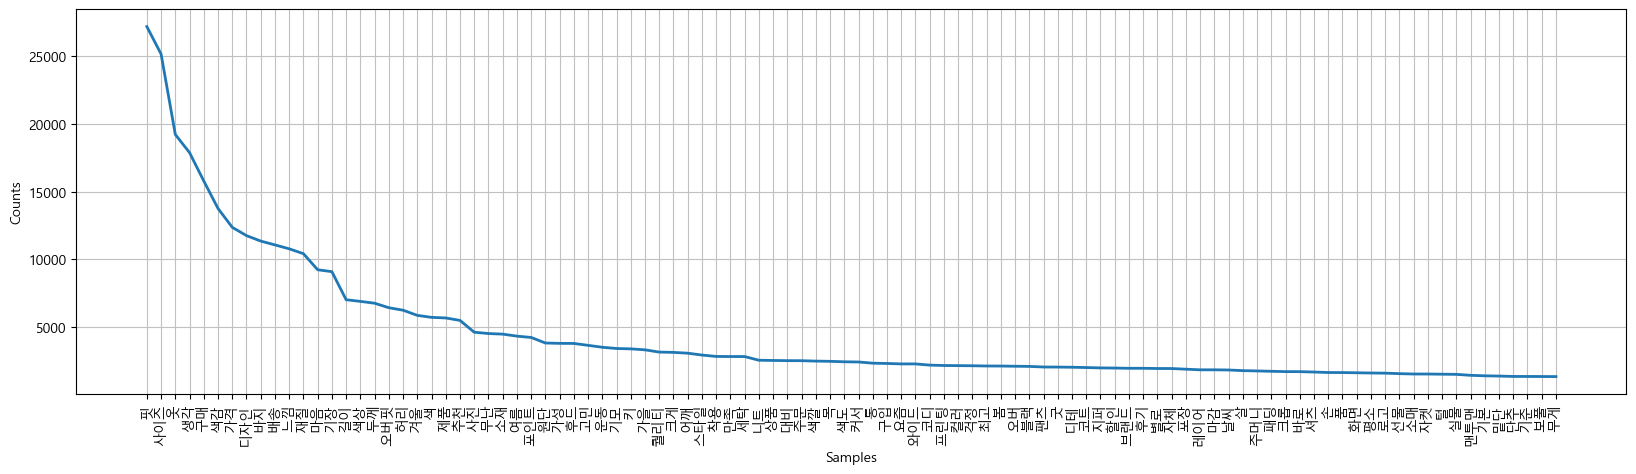

In [ ]:
plt.figure(figsize=(20, 5))
ko.plot(100)
plt.show()

In [ ]:
data_for_wc = ko.vocab().most_common(150)
dict(data_for_wc[:3])

{'핏': 27162, '사이즈': 25136, '옷': 19212}

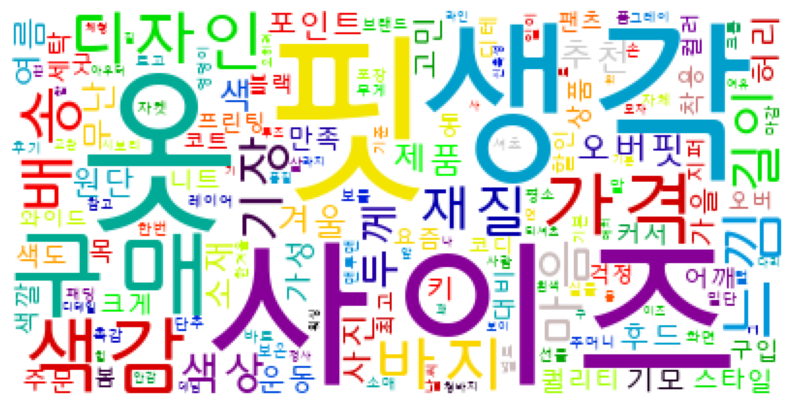

In [ ]:
wc = WordCloud(
    font_path='C:/Windows/Fonts/HYKANM.TTF',
    relative_scaling=0.1,
    background_color='white',
    colormap='nipy_spectral'
).generate_from_frequencies(dict(data_for_wc))   #빈도수 딕셔너리로 넣기

plt.figure(figsize=(10, 8))
plt.imshow(wc)
plt.axis('off')
plt.show()